variance =  1.218581118745319
lag1 =  0.72


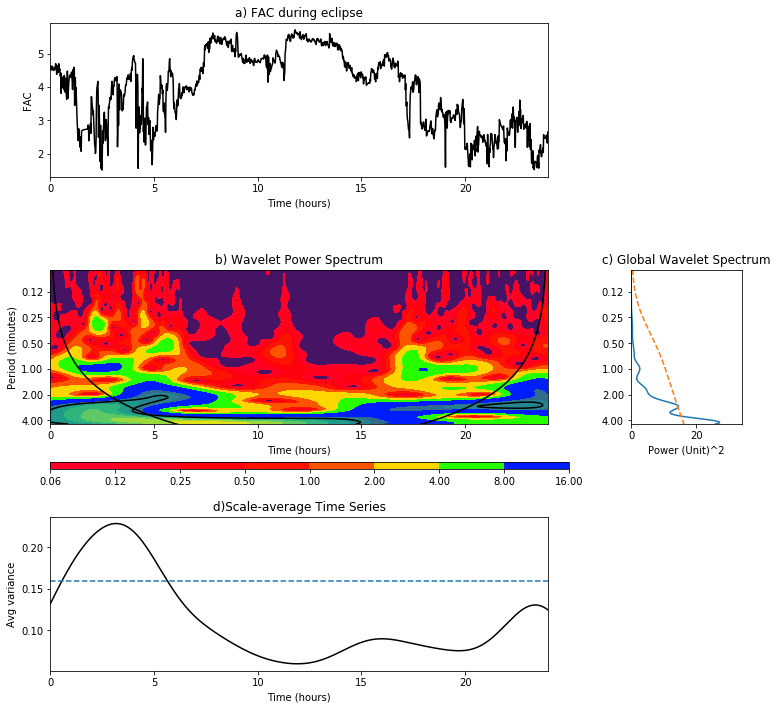

In [134]:
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

__author__ = 'Evgeniya Predybaylo'


# WAVETEST Example Python script for WAVELET, using NINO3 SST dataset
#
# See "http://paos.colorado.edu/research/wavelets/"
# The Matlab code written January 1998 by C. Torrence is modified to Python by Evgeniya Predybaylo, December 2014
#
# Modified Oct 1999, changed Global Wavelet Spectrum (GWS) to be sideways,
#   changed all "log" to "log2", changed logarithmic axis on GWS to
#   a normal axis.
# ------------------------------------------------------------------------------------------------------------------

# READ THE DATA
sst = np.loadtxt('2009-01-26.txt')  # input SST time series
#sst = sst - np.mean(sst)
variance = np.std(sst, ddof=1) ** 2
print("variance = ", variance)

#----------C-O-M-P-U-T-A-T-I-O-N------S-T-A-R-T-S------H-E-R-E------------------------------------------------------

# normalize by standard deviation (not necessary, but makes it easier
# to compare with plot on Interactive Wavelet page, at
# "http://paos.colorado.edu/research/wavelets/plot/"
if 0:
    variance = 1.0
    sst = sst / np.std(sst, ddof=1)
n = len(sst)
dt = 1/60
time = np.arange(len(sst)) * dt + 0  # construct time array
xlim = ([0, 24])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.01  # this will do 4 sub-octaves per octave
s0 = 4 * dt  # this says start at a scale of 6 months
j1 = 6/ dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
    lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

#------------------------------------------------------ Plotting

#--- Plot time series
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(3, 4, hspace=0.6, wspace=0.75) #creates a grid of 3 rows and 4 columns
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95, wspace=0, hspace=0)
plt.subplot(gs[0, 0:3]) #mathi baneko grid ko 1st row (0) ma, first 3 columns merge garne 
plt.plot(time, sst, 'k') #yo subplot ma time vs sst black color ma plot hunxa
plt.xlim(xlim[:]) #plotting ma x ko limit a to b samma
plt.xlabel('Time (hours)')
plt.ylabel('FAC')
plt.title('a) FAC during eclipse')

#plt.text(time[-1] + 35, 0.5,'Wavelet Analysis sample done by \nAshok',
    #horizontalalignment='center', verticalalignment='center')

#--- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3]) #mathi banako grid ko 2nd row ma 3ta column use garera plot garne
#levels = [0, 0.5, 1, 2, 4, 999]
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16]
CS = plt.contourf(time, period, power, len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=levels,cmap="gist_rainbow")   #or cmap=plt.colormaps()[3]


plt.xlabel('Time (hours)')
plt.ylabel('Period (minutes)')
plt.title('b) Wavelet Power Spectrum')
plt.xlim(xlim[:])
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.plot(time, coi, 'k')
# format y-scale
plt3.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()
#set up the size and location of the colorbar
position=fig.add_axes([0.1,0.33,0.6,0.01]) #left, bottom, width, height
plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)

# plt.subplots_adjust(right=0.7, top=0.9)

#--- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1,-1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (Unit)^2')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

# --- Plot 2--8 yr scale-average time series
plt.subplot(gs[2, 0:3])
plt.plot(time, scale_avg, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (hours)')
plt.ylabel('Avg variance')
plt.title('d)Scale-average Time Series')
plt.plot(xlim, scaleavg_signif + [0, 0], '--')

plt.show()
fig.savefig("latest.png",dpi=300)
# end of code

variance =  0.031554277524545586
lag1 =  0.72


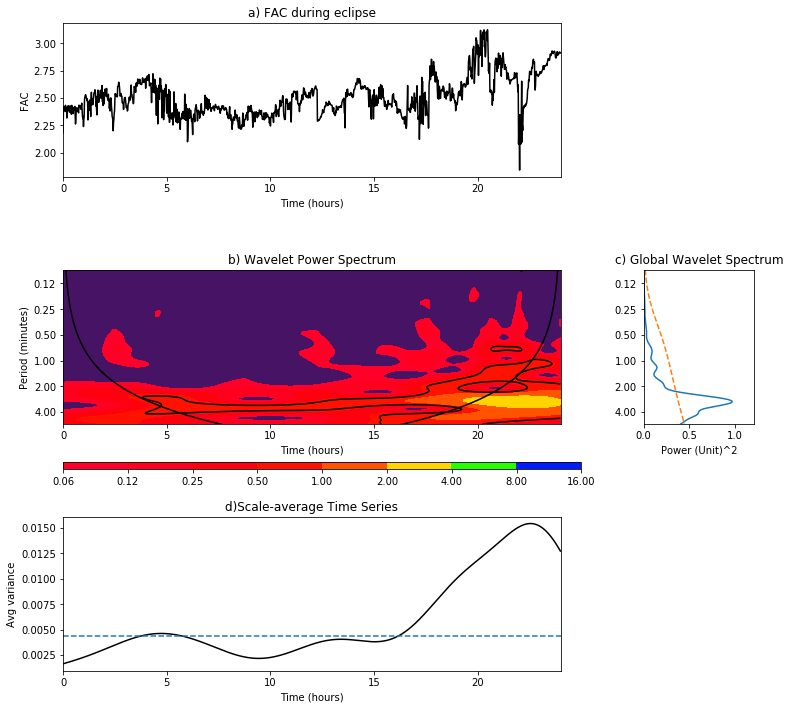

In [135]:
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

__author__ = 'Evgeniya Predybaylo'


# WAVETEST Example Python script for WAVELET, using NINO3 SST dataset
#
# See "http://paos.colorado.edu/research/wavelets/"
# The Matlab code written January 1998 by C. Torrence is modified to Python by Evgeniya Predybaylo, December 2014
#
# Modified Oct 1999, changed Global Wavelet Spectrum (GWS) to be sideways,
#   changed all "log" to "log2", changed logarithmic axis on GWS to
#   a normal axis.
# ------------------------------------------------------------------------------------------------------------------

# READ THE DATA
sst = np.loadtxt('quiet.txt')  # input SST time series
#sst = sst - np.mean(sst)
variance = np.std(sst, ddof=1) ** 2
print("variance = ", variance)

#----------C-O-M-P-U-T-A-T-I-O-N------S-T-A-R-T-S------H-E-R-E------------------------------------------------------

# normalize by standard deviation (not necessary, but makes it easier
# to compare with plot on Interactive Wavelet page, at
# "http://paos.colorado.edu/research/wavelets/plot/"
if 0:
    variance = 1.0
    sst = sst / np.std(sst, ddof=1)
n = len(sst)
dt = 1/60
time = np.arange(len(sst)) * dt + 0  # construct time array
xlim = ([0, 24])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.01  # this will do 4 sub-octaves per octave
s0 = 5 * dt  # this says start at a scale of 6 months
j1 = 6/ dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
    lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

#------------------------------------------------------ Plotting

#--- Plot time series
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(3, 4, hspace=0.6, wspace=0.75) #creates a grid of 3 rows and 4 columns
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95, wspace=0, hspace=0)
plt.subplot(gs[0, 0:3]) #mathi baneko grid ko 1st row (0) ma, first 3 columns merge garne 
plt.plot(time, sst, 'k') #yo subplot ma time vs sst black color ma plot hunxa
plt.xlim(xlim[:]) #plotting ma x ko limit a to b samma
plt.xlabel('Time (hours)')
plt.ylabel('FAC')
plt.title('a) FAC during eclipse')

#plt.text(time[-1] + 35, 0.5,'Wavelet Analysis sample done by \nAshok',
    #horizontalalignment='center', verticalalignment='center')

#--- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3]) #mathi banako grid ko 2nd row ma 3ta column use garera plot garne
#levels = [0, 0.5, 1, 2, 4, 999]
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16]
CS = plt.contourf(time, period, power, len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=levels,cmap="gist_rainbow")   #or cmap=plt.colormaps()[3]


plt.xlabel('Time (hours)')
plt.ylabel('Period (minutes)')
plt.title('b) Wavelet Power Spectrum')
plt.xlim(xlim[:])
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.plot(time, coi, 'k')
# format y-scale
plt3.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()
#set up the size and location of the colorbar
position=fig.add_axes([0.1,0.33,0.6,0.01]) #left, bottom, width, height
plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)

# plt.subplots_adjust(right=0.7, top=0.9)

#--- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1,-1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (Unit)^2')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

# --- Plot 2--8 yr scale-average time series
plt.subplot(gs[2, 0:3])
plt.plot(time, scale_avg, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (hours)')
plt.ylabel('Avg variance')
plt.title('d)Scale-average Time Series')
plt.plot(xlim, scaleavg_signif + [0, 0], '--')

plt.show()
fig.savefig("quiet.png",dpi=300)
# end of code

# If you want to understand the grid spec, see this

Text(0.5, 1.0, 'gs[-1, -2]')

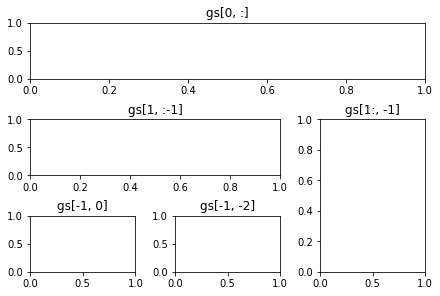

In [8]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[-1, 0])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[-1, -2])
f3_ax5.set_title('gs[-1, -2]')

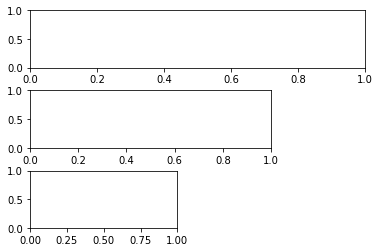

In [16]:
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75) 
plt.subplot(gs[0, :])
plt.subplot(gs[1, :3])
plt.subplot(gs[2, :2])

### What is xlim=([0,24])?

In [19]:
xlim = ([0, 24])

In [22]:
type(xlim)

list

In [23]:
len(xlim)

2

In [29]:
type(xlim[:])

list

In [32]:
xlim[:]

[0, 24]

when you use plt.xlim(), you need to pass range so xlim[:] acts as a range

In [75]:
sst

array([2.858919, 2.841181, 2.836359, ..., 1.947219, 1.934672, 1.931885])